# Importação dos dados do PMC nacional automaticamente

## Importação de dados e pacotes

In [223]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [224]:
import os
os.chdir('/content/drive/MyDrive/dados')

In [225]:
import urllib3
import json
import matplotlib.pyplot as plt
import numpy
from datetime import date


In [226]:
data_atual = date.today()
atual = data_atual.strftime('%Y%m')
atual_s = int(atual)

url_1 = 'https://servicodados.ibge.gov.br/api/v3/agregados/3416/periodos/200001'

verificador = url_1[-6:]
verificador = int(verificador)
url_2 =''
mes = 1
ano = 2000
while (verificador<atual_s):
  if (mes==13):
    mes = 1
    ano = ano + 1
    verificador = str(ano)+ '0' + str(mes)
  url_2 = url_2 + "|" + str(verificador)
  verificador = url_2[-6:]
  verificador = int(verificador) + 1
  mes = mes +1 

url_3 = '/variaveis/564?localidades=N1[all]&classificacao=11046[40311]'
url_complete = url_1+url_2+url_3
url_complete

'https://servicodados.ibge.gov.br/api/v3/agregados/3416/periodos/200001|200001|200002|200003|200004|200005|200006|200007|200008|200009|200010|200011|200012|200101|200102|200103|200104|200105|200106|200107|200108|200109|200110|200111|200112|200201|200202|200203|200204|200205|200206|200207|200208|200209|200210|200211|200212|200301|200302|200303|200304|200305|200306|200307|200308|200309|200310|200311|200312|200401|200402|200403|200404|200405|200406|200407|200408|200409|200410|200411|200412|200501|200502|200503|200504|200505|200506|200507|200508|200509|200510|200511|200512|200601|200602|200603|200604|200605|200606|200607|200608|200609|200610|200611|200612|200701|200702|200703|200704|200705|200706|200707|200708|200709|200710|200711|200712|200801|200802|200803|200804|200805|200806|200807|200808|200809|200810|200811|200812|200901|200902|200903|200904|200905|200906|200907|200908|200909|200910|200911|200912|201001|201002|201003|201004|201005|201006|201007|201008|201009|201010|201011|201012|2011

In [227]:
http = urllib3.PoolManager() 
urlPortalApiIBGE = url_complete
response = http.request('GET',urlPortalApiIBGE)
print("Response Status:", response.status)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



Response Status: 200


In [228]:
data_response = response.data.decode('utf-8')
data_response

'[{"id":"564","variavel":"Índice de volume de vendas no comércio varejista","unidade":"Número-índice","resultados":[{"classificacoes":[{"id":"11046","nome":"Tipos de índice","categoria":{"40311":"Índice base fixa (2014=100)"}}],"series":[{"localidade":{"id":"1","nivel":{"id":"N1","nome":"Brasil"},"nome":"Brasil"},"serie":{"200001":"46.0","200002":"46.5","200003":"48.5","200004":"48.5","200005":"50.5","200006":"48.1","200007":"49.8","200008":"49.7","200009":"48.4","200010":"49.4","200011":"50.3","200012":"69.3","200101":"46.9","200102":"44.2","200103":"49.7","200104":"47.6","200105":"49.4","200106":"47.5","200107":"47.8","200108":"49.1","200109":"47.1","200110":"50.0","200111":"49.1","200112":"67.4","200201":"46.4","200202":"43.5","200203":"49.9","200204":"46.6","200205":"50.0","200206":"46.6","200207":"48.6","200208":"50.2","200209":"46.4","200210":"50.3","200211":"49.1","200212":"63.9","200301":"44.3","200302":"42.8","200303":"44.2","200304":"44.9","200305":"46.9","200306":"44.0","200

In [229]:
data_json = json.loads(data_response)
data_json 

[{'id': '564',
  'resultados': [{'classificacoes': [{'categoria': {'40311': 'Índice base fixa (2014=100)'},
      'id': '11046',
      'nome': 'Tipos de índice'}],
    'series': [{'localidade': {'id': '1',
       'nivel': {'id': 'N1', 'nome': 'Brasil'},
       'nome': 'Brasil'},
      'serie': {'200001': '46.0',
       '200002': '46.5',
       '200003': '48.5',
       '200004': '48.5',
       '200005': '50.5',
       '200006': '48.1',
       '200007': '49.8',
       '200008': '49.7',
       '200009': '48.4',
       '200010': '49.4',
       '200011': '50.3',
       '200012': '69.3',
       '200101': '46.9',
       '200102': '44.2',
       '200103': '49.7',
       '200104': '47.6',
       '200105': '49.4',
       '200106': '47.5',
       '200107': '47.8',
       '200108': '49.1',
       '200109': '47.1',
       '200110': '50.0',
       '200111': '49.1',
       '200112': '67.4',
       '200201': '46.4',
       '200202': '43.5',
       '200203': '49.9',
       '200204': '46.6',
       '200

In [230]:
dados = data_json[0]
dados = dados['resultados']
dados = dados[0]
dados = dados['series']
dados = dados[0]
dados = dados['serie']
print(dados)

{'200001': '46.0', '200002': '46.5', '200003': '48.5', '200004': '48.5', '200005': '50.5', '200006': '48.1', '200007': '49.8', '200008': '49.7', '200009': '48.4', '200010': '49.4', '200011': '50.3', '200012': '69.3', '200101': '46.9', '200102': '44.2', '200103': '49.7', '200104': '47.6', '200105': '49.4', '200106': '47.5', '200107': '47.8', '200108': '49.1', '200109': '47.1', '200110': '50.0', '200111': '49.1', '200112': '67.4', '200201': '46.4', '200202': '43.5', '200203': '49.9', '200204': '46.6', '200205': '50.0', '200206': '46.6', '200207': '48.6', '200208': '50.2', '200209': '46.4', '200210': '50.3', '200211': '49.1', '200212': '63.9', '200301': '44.3', '200302': '42.8', '200303': '44.2', '200304': '44.9', '200305': '46.9', '200306': '44.0', '200307': '46.5', '200308': '47.3', '200309': '45.1', '200310': '48.8', '200311': '49.0', '200312': '66.0', '200401': '47.0', '200402': '45.0', '200403': '49.1', '200404': '49.5', '200405': '51.9', '200406': '49.7', '200407': '52.1', '200408':

## Dados organizados para análise e visualização

In [231]:
import pandas as pd
pmc = pd.DataFrame.from_dict(dados, orient='index').rename(columns={0:'pmc_valor'})
pmc.pmc_valor = pmc.pmc_valor.astype(float)
pmc

,pmc_valor
200001,46.0
200002,46.5
200003,48.5
200004,48.5
200005,50.5
...,...
202103,91.3
202104,91.7
202105,99.6
202106,95.9


In [232]:
pmc.describe()

,pmc_valor
count,259.000000
mean,76.139382
std,21.216095
min,42.800000
25%,53.650000
50%,81.700000
75%,91.800000
max,130.300000


In [233]:
# importar pacotes e setar configurações de plots
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
 

In [234]:
data_final = str(pmc.index[-1])
data_final

'202107'

In [235]:
data_inicial = str(pmc.index[0])
data_inicial

'200001'

In [236]:
date_1 = '{}--{}'.format(str(data_inicial[4:6]),str(data_inicial[0:4]))
date_2 = '{}--{}'.format(str(data_final[4:6]),str(data_final[0:4]))
date_2

'07--2021'

In [237]:
pmc.shape[0]

259

In [238]:
pd.date_range(date_1, periods=pmc.shape[0], freq='M')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31'],
              dtype='datetime64[ns]', length=259, freq='M')

In [239]:
pmc.index = pd.date_range(date_1, periods=pmc.shape[0], freq='M')
indices = pmc.index
indices

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31'],
              dtype='datetime64[ns]', length=259, freq='M')

In [240]:
pmc.to_csv('pmc.csv')

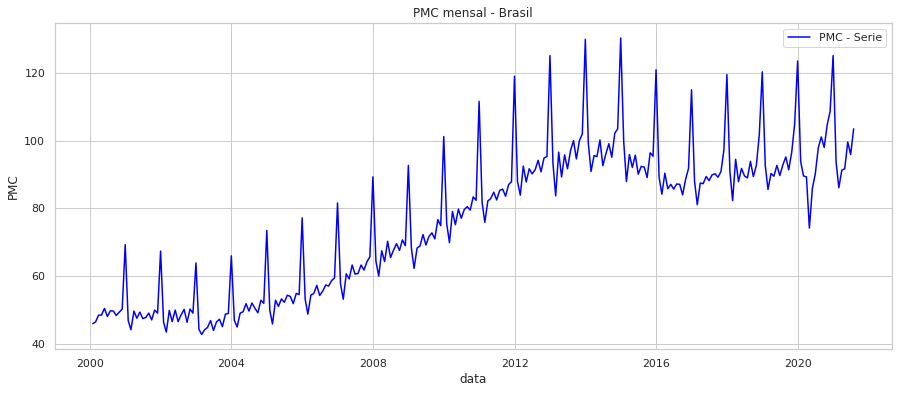

In [241]:
plt.figure(figsize=(15, 6))
plt.title("PMC mensal - Brasil")
plt.plot(pmc,label="PMC - Serie",color="blue")
plt.xlabel("data")
plt.ylabel("PMC")
plt.legend()
plt.savefig('pmcserie.png', format='png')

<Figure size 1440x432 with 0 Axes>

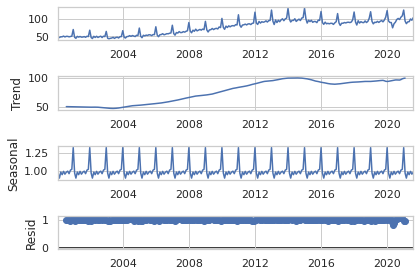

In [242]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = pmc

decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
plt.figure(figsize=(20, 6))
decompose_result_mult.plot()
plt.savefig('decompose.png', format='png')

In [243]:
!pip install pmdarima

In [244]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from datetime import datetime
#registro de converters para uso do matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [245]:
# Implementação do auto arima para descoberta automática dos parâmetros
modelo_auto = auto_arima(analysis['pmc_valor'], m = 12, seasonal = True, trace = True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1143.711, Time=2.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1429.080, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1166.105, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1295.085, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1493.494, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1141.714, Time=1.55 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=1177.363, Time=0.56 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1143.711, Time=3.33 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1147.490, Time=1.47 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1145.696, Time=3.99 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1142.735, Time=1.28 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1142.333, Time=1.70 sec
 ARIMA(3,0,2)(0,1,1)[12] intercept   : AIC=1142.409, Time=3.04 sec
 ARIMA(2,0,3)(0,1,1)[12] intercept   : AIC=1143.226, Time=1.92 sec
 ARIMA(1,0,1)(0,1,1

In [246]:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  259
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -563.857
Date:                              Thu, 16 Sep 2021   AIC                           1141.714
Time:                                      05:03:48   BIC                           1166.279
Sample:                                           0   HQIC                          1151.604
                                              - 259                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1438      0.105      1.366      0.172      -0.062       0.350
ar.L1          0.2500      0.147      1.706      0.088      -0.037       0.537
ar.L2          0.6910      0.139      4.965      0.000       0.418       0.964
ma.L1          0.3978      0.141      2.818      0.005       0.121       0.674
ma.L2         -0.3866      0.065     -5.906      0.000      -0.515      -0.258
ma.S.L12      -0.4745      0.044    -10.742      0.000      -0.561      -0.388
sigma2         5.5287      0.353     15.645      0.000       4.836       6.221
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               452.35
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               5.50   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
proximos_24 = modelo_auto.predict(n_periods = 24)
# Visualização dos próximos 12 valores
proximos_24

array([105.82888787, 102.01251085, 107.75083209, 113.08465709,
       131.12784293, 100.64776442,  93.93211201,  98.0253212 ,
        93.8498742 , 101.52480219,  99.99530568, 106.24542388,
       108.77742243, 105.10806822, 110.70584525, 116.10612042,
       134.06880901, 103.61452029,  96.84969532, 100.94843095,
        96.74038952, 104.41098743, 102.85788709, 109.09911245])

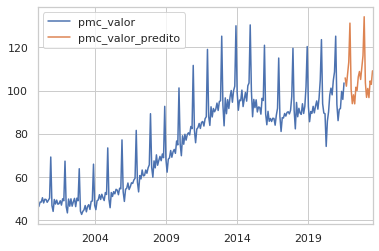

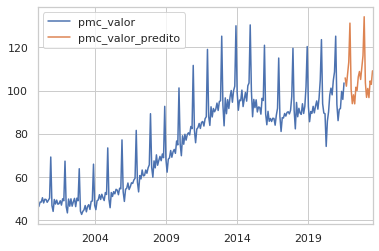

In [248]:
from datetime import datetime, timedelta

data_final_c = date.today()- timedelta(days=30)
future_forecast = pd.DataFrame({'pmc_valor_predito':proximos_24}, index=pd.date_range(data_final_c, periods=24, freq='M'))
pd.concat([analysis,future_forecast],axis=1).plot()
previsao = pd.concat([analysis,future_forecast],axis=1).plot()
plt.savefig('previsao.png', format='png')

In [249]:
import plotly.express as px
import pandas as pd
dados_vis = analysis
dados_vis['Data'] = dados_vis.index
dados_vis

fig = px.line(dados_vis, x='Data', y='pmc_valor', title='Série temporal do PMC nacional')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [250]:
!pip install chart_studio
!pip install cufflinks 
!pip install plotly
!pip install --upgrade plotly 


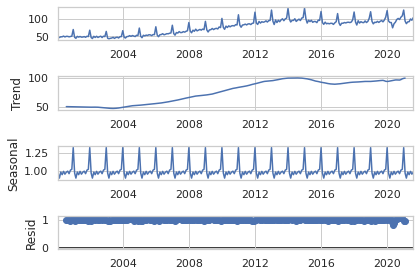

In [251]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import iplot


result = decompose_result_mult
fig = result.plot()
fig.show()

In [252]:
!pip install dash


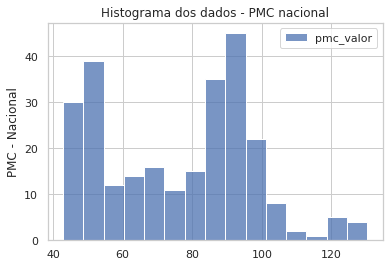

In [253]:
sns.histplot(analysis[['pmc_valor']], bins=15, color='purple')
plt.ylabel('PMC - Nacional')
plt.title('Histograma dos dados - PMC nacional')
plt.xlabel(None)
plt.xticks()
plt.savefig('histograma.png', format='png')

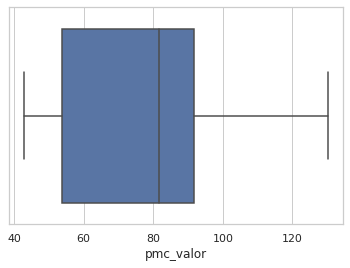

In [254]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=analysis["pmc_valor"])
plt.savefig('boxplot.png', format='png')

# Visualizações do PMC - Nacional - Report

In [255]:
import plotly.express as px
import pandas as pd
dados_vis = analysis
dados_vis['Data'] = dados_vis.index
dados_vis

fig = px.line(dados_vis, x='Data', y='pmc_valor', title='Série temporal do PMC nacional')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [256]:
# Modelo selecionado - SAMIRA
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  259
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -563.857
Date:                              Thu, 16 Sep 2021   AIC                           1141.714
Time:                                      05:04:07   BIC                           1166.279
Sample:                                           0   HQIC                          1151.604
                                              - 259                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1438      0.105      1.366      0.172      -0.062       0.350
ar.L1          0.2500      0.147      1.706      0.088      -0.037       0.537
ar.L2          0.6910      0.139      4.965      0.000       0.418       0.964
ma.L1          0.3978      0.141      2.818      0.005       0.121       0.674
ma.L2         -0.3866      0.065     -5.906      0.000      -0.515      -0.258
ma.S.L12      -0.4745      0.044    -10.742      0.000      -0.561      -0.388
sigma2         5.5287      0.353     15.645      0.000       4.836       6.221
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               452.35
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               5.50   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

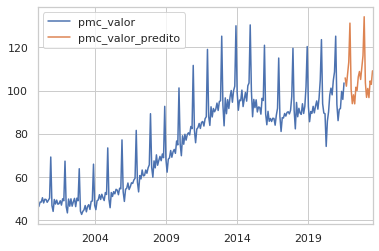

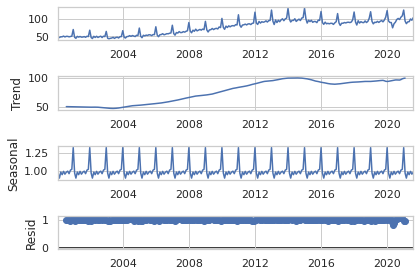

In [257]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import iplot


result = decompose_result_mult
fig = result.plot()
fig.show()

(array([ 20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 7 Text major ticklabel objects>)

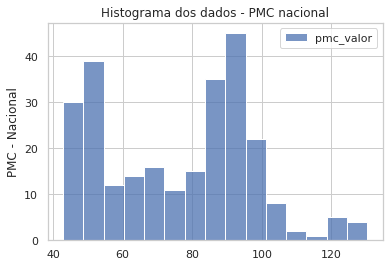

In [258]:
sns.histplot(analysis[['pmc_valor']], bins=15, color='purple')
plt.ylabel('PMC - Nacional')
plt.title('Histograma dos dados - PMC nacional')
plt.xlabel(None)
plt.xticks()